In [ ]:
# loading data from fast ai
!wget https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz

--2021-05-22 14:46:38--  https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.100.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.100.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 598913237 (571M) [application/x-tar]
Saving to: ‘camvid.tgz’

camvid.tgz          100%[===================>] 571.17M  16.3MB/s    in 36s     

2021-05-22 14:47:15 (15.7 MB/s) - ‘camvid.tgz’ saved [598913237/598913237]



In [ ]:
import shutil
# decompression
shutil.unpack_archive("camvid.tgz", "/content/")

In [ ]:
# !pip install -U segmentation-models-pytorch albumentations --userimport torch
import torch.nn as nn
import torch
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision.transforms import ToTensor
import torchvision.transforms as t
import albumentations as A
import os
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output
from tqdm.notebook import  tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import cv2
import albumentations as albu
from tqdm.notebook import  tqdm
!nvidia-smi

Sat May 22 14:46:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    35W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Model

In [ ]:
# creating a double conv class for cleaner implementation
class DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(DoubleConv,self).__init__()
    self.convs=nn.Sequential(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=1,padding=1,bias=False)
    ,nn.BatchNorm2d(out_channels)
    ,nn.ReLU(True)
    ,nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,stride=1,padding=1)
    ,nn.BatchNorm2d(out_channels)
    ,nn.ReLU(True)
    ,nn.Dropout2d(0.1)
    )


  def forward(self,X):
    return self.convs(X)


class UNet(nn.Module):
  def __init__(self,in_channels,out_channels,feature_list=[64,128,256,512]):
    super(UNet,self).__init__()
    self.downward=nn.ModuleList()
    self.upward=nn.ModuleList()
    self.pool=nn.MaxPool2d(2,stride=2)



    ## downward path:
    for feature in feature_list:
      self.downward.append(DoubleConv(in_channels=in_channels,out_channels=feature))
      in_channels=feature


    ## upward path:
    for feature in reversed(feature_list):
      self.upward.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
      self.upward.append(DoubleConv(in_channels=feature*2,out_channels=feature))

    self.bottleneck=DoubleConv(in_channels=feature_list[-1],out_channels=feature_list[-1]*2)
    self.output=nn.Conv2d(feature_list[0],out_channels=out_channels,kernel_size=1)
  


  def forward(self,X):
    reses=[] # skip connections
    for down in self.downward:
      X=down(X)
      reses.append(X)
      X=self.pool(X)
    
    X=self.bottleneck(X)
    reses=reses[::-1]


    for i in range(0,len(self.upward),2):
      X=self.upward[i](X)
      res=reses[i//2]
      if X.shape!=res.shape:
        X=F.resize(X,size=res.shape[2:])
      cat_res=torch.cat((res,X),dim=1)
      X=self.upward[i+1](cat_res)

    return self.output(X)



# data preprocessing

In [ ]:
# cleaning file names
 
cur_path ='/content/camvid/labels' 
 
labels = os.listdir(cur_path)
 
for label in labels:
    old_label = str(label)
    new_label = label.replace('_P.png','.png')
    print(old_label, new_label)
    os.rename(os.path.join(cur_path,old_label),os.path.join(cur_path,new_label))


0006R0_f02520_P.png 0006R0_f02520.png
Seq05VD_f03300_P.png Seq05VD_f03300.png
0016E5_08097_P.png 0016E5_08097.png
0016E5_04980_P.png 0016E5_04980.png
0016E5_02310_P.png 0016E5_02310.png
0006R0_f01230_P.png 0006R0_f01230.png
Seq05VD_f04920_P.png Seq05VD_f04920.png
0016E5_07993_P.png 0016E5_07993.png
0016E5_06600_P.png 0016E5_06600.png
Seq05VD_f01830_P.png Seq05VD_f01830.png
0016E5_06390_P.png 0016E5_06390.png
0016E5_02280_P.png 0016E5_02280.png
0016E5_04650_P.png 0016E5_04650.png
0006R0_f02100_P.png 0006R0_f02100.png
0016E5_08310_P.png 0016E5_08310.png
0016E5_01590_P.png 0016E5_01590.png
0001TP_008130_P.png 0001TP_008130.png
0016E5_05820_P.png 0016E5_05820.png
0001TP_009690_P.png 0001TP_009690.png
0016E5_07987_P.png 0016E5_07987.png
Seq05VD_f04950_P.png Seq05VD_f04950.png
0016E5_00420_P.png 0016E5_00420.png
0006R0_f01830_P.png 0006R0_f01830.png
0006R0_f03180_P.png 0006R0_f03180.png
Seq05VD_f00930_P.png Seq05VD_f00930.png
0006R0_f03060_P.png 0006R0_f03060.png
Seq05VD_f02640_P.png Seq05VD

In [ ]:
# Data set path
dataset_path = '/content/camvid'
images_path = '/content/camvid/images'
labels_path   = '/content/camvid/labels'
 
images_name = os.listdir(images_path)
images_name.remove('test.txt')
images_num  = len(images_name)
alpha  = int( images_num  * 0.7 )
beta   = int( images_num  * 0.9 )
 
print(images_num)
 
random.shuffle(images_name)
 
train_list = images_name[0:alpha]
valid_list = images_name[alpha:beta]
test_list  = images_name[beta:images_num]
 
 # Confirm the segmentation is correct
print('train list: ',len(train_list))
print('valid list: ',len(valid_list))
print('test list: ',len(test_list))
print('total num: ',len(test_list)+len(valid_list)+len(train_list))
 
 # Create train, valid and test folders
train_images_path = os.path.join(dataset_path,'train_images')
train_labels_path  = os.path.join(dataset_path,'train_labels')
if os.path.exists(train_images_path)==False:
    os.mkdir(train_images_path )
if os.path.exists(train_labels_path)==False:
    os.mkdir(train_labels_path)
 
valid_images_path = os.path.join(dataset_path,'valid_images')
valid_labels_path  = os.path.join(dataset_path,'valid_labels')
if os.path.exists(valid_images_path)==False:
    os.mkdir(valid_images_path )
if os.path.exists(valid_labels_path)==False:
    os.mkdir(valid_labels_path)
 
test_images_path = os.path.join(dataset_path,'test_images')
test_labels_path  = os.path.join(dataset_path,'test_labels')
if os.path.exists(test_images_path)==False:
    os.mkdir(test_images_path )
if os.path.exists(test_labels_path)==False:
    os.mkdir(test_labels_path)
 
 # Copy the image to the specified directory
for image in train_list:
    shutil.copy(os.path.join(images_path,image), os.path.join(train_images_path,image))
    shutil.copy(os.path.join(labels_path,image), os.path.join(train_labels_path,image))
 
for image in valid_list:
    shutil.copy(os.path.join(images_path,image), os.path.join(valid_images_path,image))
    shutil.copy(os.path.join(labels_path,image), os.path.join(valid_labels_path,image))
 
for image in test_list:
    shutil.copy(os.path.join(images_path,image), os.path.join(test_images_path,image))
    shutil.copy(os.path.join(labels_path,image), os.path.join(test_labels_path,image))

701
train list:  490
valid list:  140
test list:  71
total num:  701


In [ ]:

DATA_DIR ='/content/camvid'
 
x_train_dir = os.path.join(DATA_DIR, 'train_images')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')
 
x_valid_dir = os.path.join(DATA_DIR, 'valid_images')
y_valid_dir = os.path.join(DATA_DIR, 'valid_labels')
 
x_test_dir = os.path.join(DATA_DIR, 'test_images')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')


In [ ]:
class camvid(Dataset):

    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.augmentation = augmentation
 
    
    def __getitem__(self, i):
                
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
                 
        
        mask = mask.astype('float')   
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
       
                 
        return torch.from_numpy(image.reshape(3,80, 80 )).float(), torch.from_numpy(mask.reshape(80,80)).long()
        
    def __len__(self):
        return len(self.ids)
 
 # Data augmentation


def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.Resize(height=80, width=80, always_apply=True,interpolation= cv2.INTER_NEAREST),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=20, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)
 
def get_test_augmentation():
    train_transform = [
        albu.Resize(height=80, width=80, always_apply=True,interpolation= cv2.INTER_NEAREST),
    ]
    return albu.Compose(train_transform)                                         
 
augmented_dataset = camvid(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)


In [ ]:
trainset=camvid(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)

valset=camvid(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_test_augmentation(), 
)
testset=camvid(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_test_augmentation(), 
)

In [ ]:
trainloader=DataLoader(trainset,batch_size=2,num_workers=0,shuffle=True)
valloader=DataLoader(valset,batch_size=2,num_workers=0,shuffle=True)
testloader=DataLoader(testset,batch_size=4,num_workers=0,shuffle=False)

# trainer

train_loss  val_loss
0      2.628204  2.186494
1      1.859870  1.783590
2      1.588579  1.634500
3      1.475592  1.518210
4      1.399884  1.457860
5      1.365137  1.414839
6      1.327706  1.430111
7      1.314410  1.374532
8      1.289044  1.371293
9      1.266817  1.318915
10     1.253489  1.306499
11     1.242780  1.308305
12     1.229861  1.310885
13     1.218948  1.353284
14     1.207297  1.303212
15     1.196994  1.271247
16     1.197482  1.296447
17     1.185781  1.287223
18     1.181972  1.271046
19     1.167082  1.275602
20     1.164689  1.226273
21     1.161855  1.259609
22     1.153660  1.239848
23     1.156568  1.263421
24     1.141534  1.278692
25     1.144761  1.216670
26     1.143960  1.259261
27     1.129101  1.198832
28     1.128971  1.267555
29     1.113028  1.257703
30     1.120870  1.194507
31     1.115685  1.208340
32     1.114189  1.261893
33     1.104775  1.190625
34     1.107332  1.191235
35     1.097466  1.257676
36     1.099301  1.190697
37     1.092675  1.176834
38     1.088331  1.166482
39     1.083207  1.208089
40     1.087813  1.153377
41     1.080681  1.170027
42     1.072198  1.166238
43     1.081730  1.152924
44     1.069923  1.141691
45     1.062183  1.157263
46     1.061035  1.183966
47     1.072760  1.178203
48     1.066734  1.183939
49     1.066188  1.146783
50     1.063341  1.136949
51     1.047048  1.120264
52     1.049487  1.110748
53     1.048703  1.134241
54     1.043799  1.092974
55     1.040281  1.115190
56     1.027337  1.158365
57     1.036354  1.137260
58     1.033599  1.106939
59     1.036204  1.131911
60     1.036928  1.100281
61     1.028034  1.098099
62     1.024549  1.119159
63     1.027828  1.091545
64     1.025937  1.089814
65     1.023231  1.073571
66     1.005752  1.069525
67     1.014474  1.069471
68     1.005084  1.049410
69     1.005166  1.098810
70     1.009196  1.060051
71     1.013901  1.096388
72     1.007986  1.088756
73     1.002482  1.106450
74     1.002044  1.074565
75     0.985277  1.076402
76     0.986643  1.070160
77     0.991710  1.060117
78     0.992860  1.048528
79     0.986078  1.072749
80     0.974246  1.111902
81     0.990258  1.057681
82     0.976946  1.065337
83     0.972253  1.050814
84     0.974853  1.020221
85     0.967919  1.077652
86     0.968874  1.053495
87     0.971208  1.061455
88     0.966236  1.015359
89     0.968273  1.008891
90     0.961467  1.060417
91     0.968932  1.020467
92     0.953076  1.020712
93     0.956063  0.982129
94     0.950295  1.000480
95     0.950894  1.008632
96     0.946143  1.018660
97     0.952155  0.999984
98     0.953320  1.036114
99     0.950465  1.026697
100    0.934305  1.057928
101    0.938781  0.999978
102    0.949692  1.029843
103    0.932304  1.035361
104    0.927734  1.015555
105    0.931300  0.999777
106    0.935473  1.008897
107    0.914636  0.950433
108    0.920559  0.983368
109    0.923173  0.945855
110    0.907770  0.984977
111    0.921237  0.952465
112    0.916950  0.997319
113    0.918817  0.983481
114    0.909081  0.990967
115    0.905625  0.981592
116    0.911344  0.986960
117    0.911901  0.952418
118    0.912024  0.965535
119    0.904915  0.941438
120    0.899764  0.969882
121    0.897959  0.939651
122    0.910761  0.940902
123    0.887627  0.956608
124    0.889331  0.981088
125    0.901975  0.949111
126    0.889360  1.015315
127    0.882464  0.938568
128    0.884317  0.924665
129    0.877917  0.951753
130    0.888962  0.938701
131    0.887808  0.918661
132    0.870432  0.943754
133    0.875712  0.937498
134    0.873730  0.902000
135    0.874578  0.919473
136    0.871974  0.944112
137    0.874323  0.939725
138    0.875256  0.921006
139    0.871444  0.922629
140    0.872845  0.911696
141    0.858890  0.929318
142    0.858136  0.922844
143    0.863580  0.959783
144    0.854424  0.913774
145    0.852626  0.932787
146    0.857127  0.910389
147    0.845556  0.894025
148    0.850032  0.887080
149    0.849425  0.896526
150    0.847485  0.922000
151    0.856717  0.884907
152    0.851265  0.892574
1

train_loss  val_loss
0      2.628204  2.186494
1      1.859870  1.783590
2      1.588579  1.634500
3      1.475592  1.518210
4      1.399884  1.457860
5      1.365137  1.414839
6      1.327706  1.430111
7      1.314410  1.374532
8      1.289044  1.371293
9      1.266817  1.318915
10     1.253489  1.306499
11     1.242780  1.308305
12     1.229861  1.310885
13     1.218948  1.353284
14     1.207297  1.303212
15     1.196994  1.271247
16     1.197482  1.296447
17     1.185781  1.287223
18     1.181972  1.271046
19     1.167082  1.275602
20     1.164689  1.226273
21     1.161855  1.259609
22     1.153660  1.239848
23     1.156568  1.263421
24     1.141534  1.278692
25     1.144761  1.216670
26     1.143960  1.259261
27     1.129101  1.198832
28     1.128971  1.267555
29     1.113028  1.257703
30     1.120870  1.194507
31     1.115685  1.208340
32     1.114189  1.261893
33     1.104775  1.190625
34     1.107332  1.191235
35     1.097466  1.257676
36     1.099301  1.190697
37     1.092675  1.176834
38     1.088331  1.166482
39     1.083207  1.208089
40     1.087813  1.153377
41     1.080681  1.170027
42     1.072198  1.166238
43     1.081730  1.152924
44     1.069923  1.141691
45     1.062183  1.157263
46     1.061035  1.183966
47     1.072760  1.178203
48     1.066734  1.183939
49     1.066188  1.146783
50     1.063341  1.136949
51     1.047048  1.120264
52     1.049487  1.110748
53     1.048703  1.134241
54     1.043799  1.092974
55     1.040281  1.115190
56     1.027337  1.158365
57     1.036354  1.137260
58     1.033599  1.106939
59     1.036204  1.131911
60     1.036928  1.100281
61     1.028034  1.098099
62     1.024549  1.119159
63     1.027828  1.091545
64     1.025937  1.089814
65     1.023231  1.073571
66     1.005752  1.069525
67     1.014474  1.069471
68     1.005084  1.049410
69     1.005166  1.098810
70     1.009196  1.060051
71     1.013901  1.096388
72     1.007986  1.088756
73     1.002482  1.106450
74     1.002044  1.074565
75     0.985277  1.076402
76     0.986643  1.070160
77     0.991710  1.060117
78     0.992860  1.048528
79     0.986078  1.072749
80     0.974246  1.111902
81     0.990258  1.057681
82     0.976946  1.065337
83     0.972253  1.050814
84     0.974853  1.020221
85     0.967919  1.077652
86     0.968874  1.053495
87     0.971208  1.061455
88     0.966236  1.015359
89     0.968273  1.008891
90     0.961467  1.060417
91     0.968932  1.020467
92     0.953076  1.020712
93     0.956063  0.982129
94     0.950295  1.000480
95     0.950894  1.008632
96     0.946143  1.018660
97     0.952155  0.999984
98     0.953320  1.036114
99     0.950465  1.026697
100    0.934305  1.057928
101    0.938781  0.999978
102    0.949692  1.029843
103    0.932304  1.035361
104    0.927734  1.015555
105    0.931300  0.999777
106    0.935473  1.008897
107    0.914636  0.950433
108    0.920559  0.983368
109    0.923173  0.945855
110    0.907770  0.984977
111    0.921237  0.952465
112    0.916950  0.997319
113    0.918817  0.983481
114    0.909081  0.990967
115    0.905625  0.981592
116    0.911344  0.986960
117    0.911901  0.952418
118    0.912024  0.965535
119    0.904915  0.941438
120    0.899764  0.969882
121    0.897959  0.939651
122    0.910761  0.940902
123    0.887627  0.956608
124    0.889331  0.981088
125    0.901975  0.949111
126    0.889360  1.015315
127    0.882464  0.938568
128    0.884317  0.924665
129    0.877917  0.951753
130    0.888962  0.938701
131    0.887808  0.918661
132    0.870432  0.943754
133    0.875712  0.937498
134    0.873730  0.902000
135    0.874578  0.919473
136    0.871974  0.944112
137    0.874323  0.939725
138    0.875256  0.921006
139    0.871444  0.922629
140    0.872845  0.911696
141    0.858890  0.929318
142    0.858136  0.922844
143    0.863580  0.959783
144    0.854424  0.913774
145    0.852626  0.932787
146    0.857127  0.910389
147    0.845556  0.894025
148    0.850032  0.887080
149    0.849425  0.896526
150    0.847485  0.922000
151    0.856717  0.884907
152    0.851265  0.892574
1

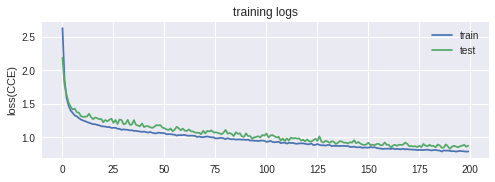

In [ ]:

class trainer:
  def __init__(self,model,criterion):
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model=model.to(self.device)
    self.optimizer=torch.optim.Adam(self.model.parameters(), lr=0.0001,weight_decay=1e-8)
    self.criterion=criterion
    

    self.history_dict={'train_loss':[],'val_loss':[]}
    
  def train(self,trainloader):
    loss_batch=[]
    metric_batch=[]
    self.model.train()
    loop=tqdm(trainloader,leave=True,total=len(trainloader))
    for X,y in loop:
      X=X.to(self.device)
      y=y.to(self.device)
      out=model(X)
      self.optimizer.zero_grad()
      loss=self.criterion(out,y)
      loss.backward()
      loss=loss.item()
      loss_batch.append(loss)
      self.optimizer.step()
      with torch.no_grad():
        
        loop.set_description(f'training')
        loop.set_postfix(loss=loss)
    return loss_batch,metric_batch

  def validation(self,valloader):
    loss_batch=[]
    metric_batch=[]
    self.model.eval()
    with torch.no_grad():
      loop=tqdm(valloader,leave=True,total=len(valloader))
      for X,y in loop:
        X=X.to(self.device)
        y=y.to(self.device)
        out=self.model(X)
        loss=self.criterion(out,y).item()
        loss_batch.append(loss)

        loop.set_description(f'validating')
        loop.set_postfix(loss=loss)
    return loss_batch,metric_batch


  def fit(self,trainloader,valloader,epochs):
    pd.set_option('display.max_rows', epochs)

    for epoch in range(epochs):

      train_loss,train_metric=self.train(trainloader)
      val_loss,val_metric=self.validation(valloader)

      self.history_dict['train_loss'].append(np.mean(train_loss))
      self.history_dict['val_loss'].append(np.mean(val_loss))

      self.history=pd.DataFrame(self.history_dict)
      if epoch!=(epochs-1):
        clear_output()
      display(self.history.head(epochs))
    


def plot_logs(train,title='training logs'):
  plt.style.use('seaborn')
  plt.subplot(2,1,1)
  train.history['train_loss'].plot()
  train.history['val_loss'].plot()
  plt.title(title)
  plt.grid('on')
  plt.legend(['train','test'])
  plt.ylabel('loss(CCE)')




model=UNet(in_channels=3,out_channels=50)
criterion=nn.CrossEntropyLoss()
train=trainer(model,criterion)
train.fit(trainloader,valloader,200)
plot_logs(train,'training logs')

# save checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save( train.model.state_dict(), '/content/drive/MyDrive/extra_hw/check.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load checkpoint

In [ ]:
model=UNet(in_channels=3,out_channels=50)
from google.colab import drive
drive.mount('/content/drive')
model.load_state_dict(torch.load( '/content/drive/MyDrive/extra_hw/check.pt'))

Mounted at /content/drive


<All keys matched successfully>

In [ ]:
testloader=DataLoader(testset,batch_size=1,num_workers=0,shuffle=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


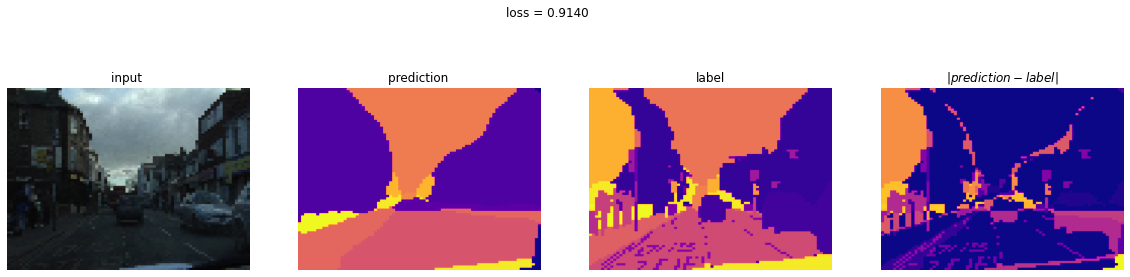

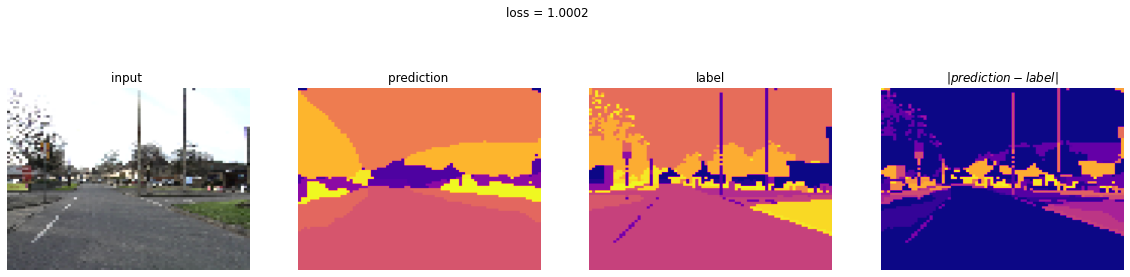

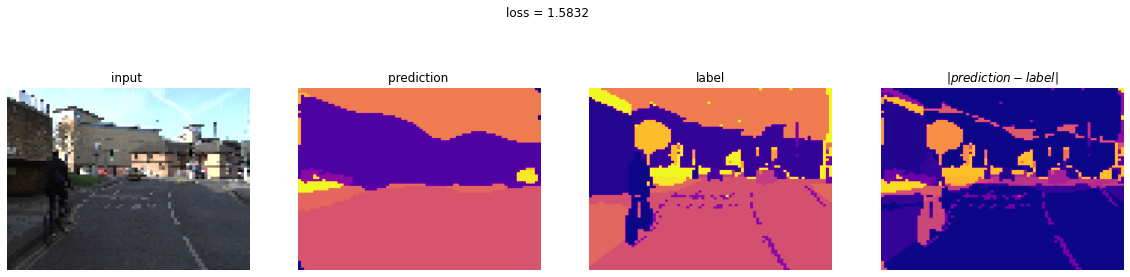

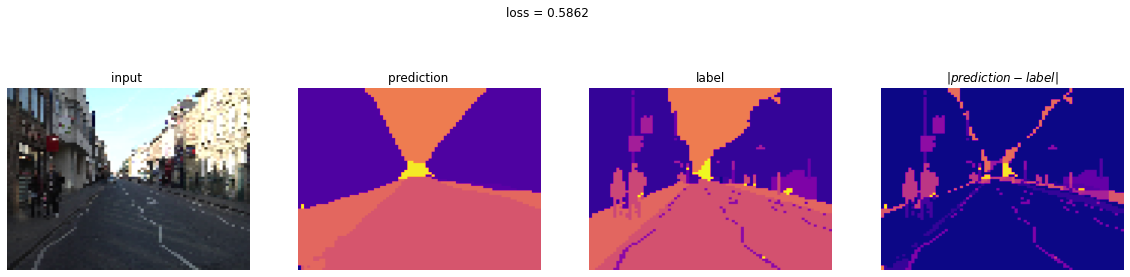

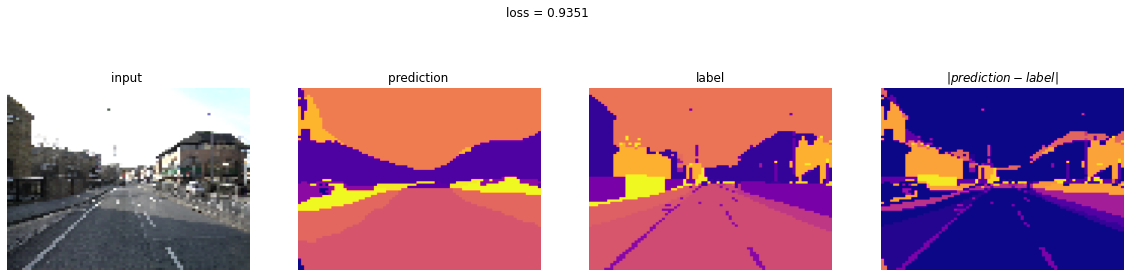

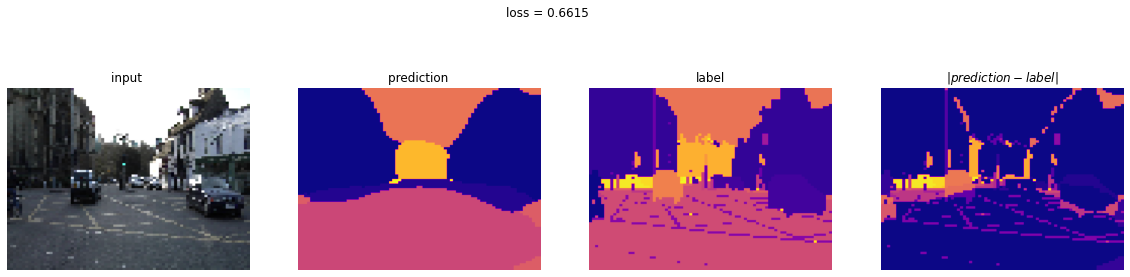

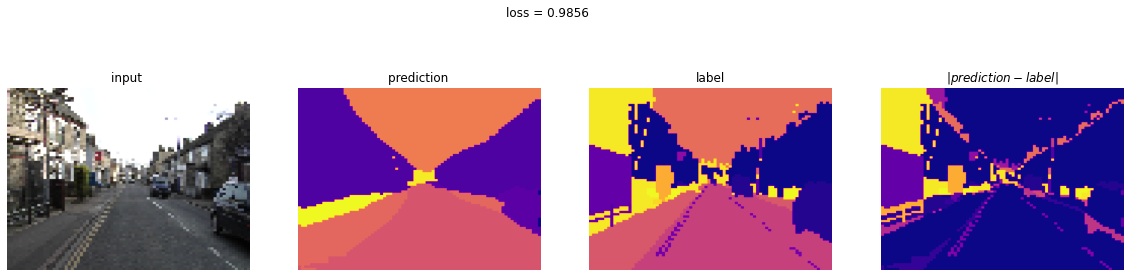

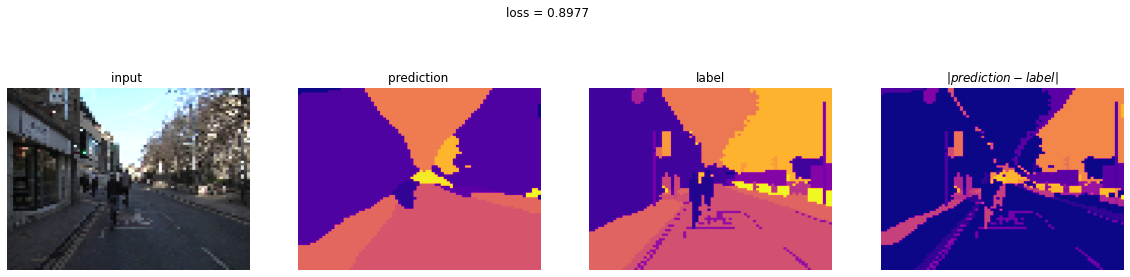

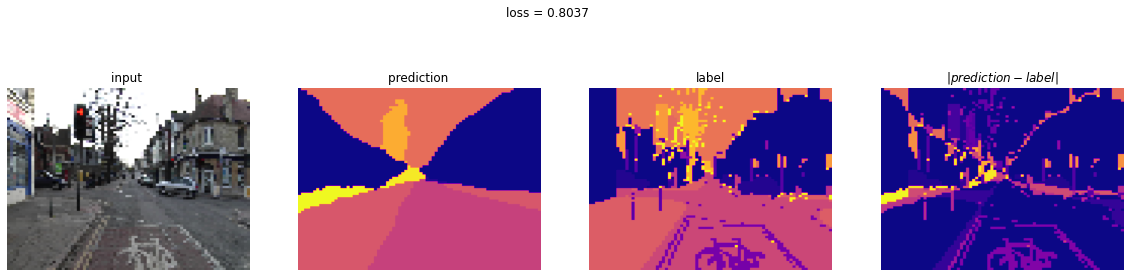

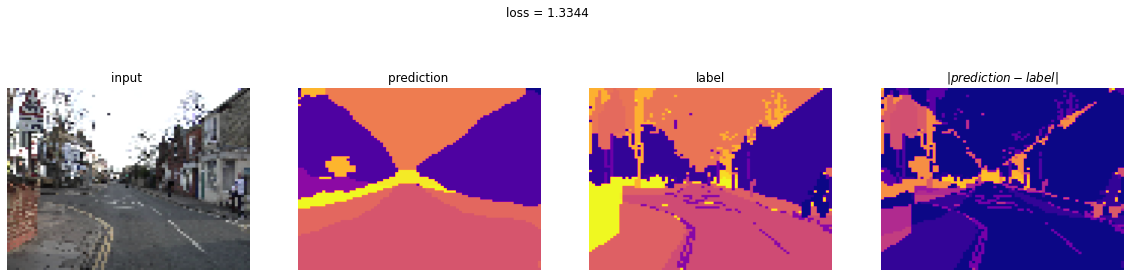

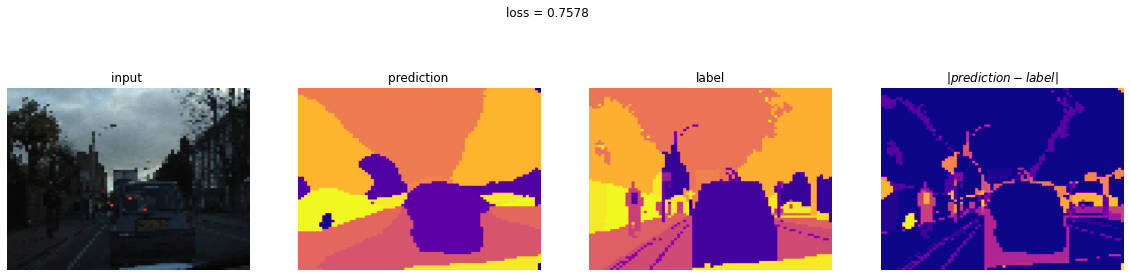

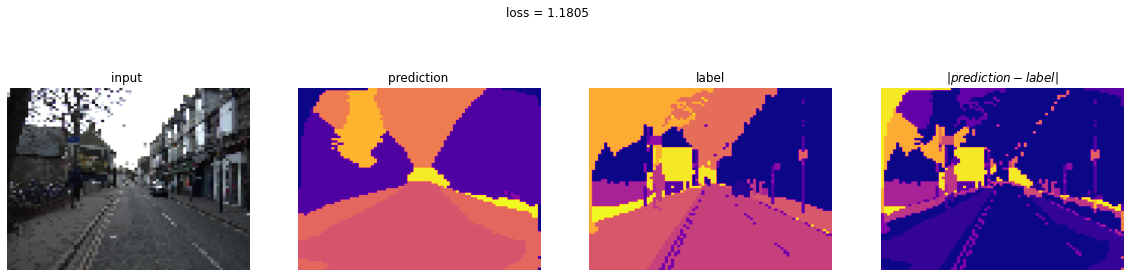

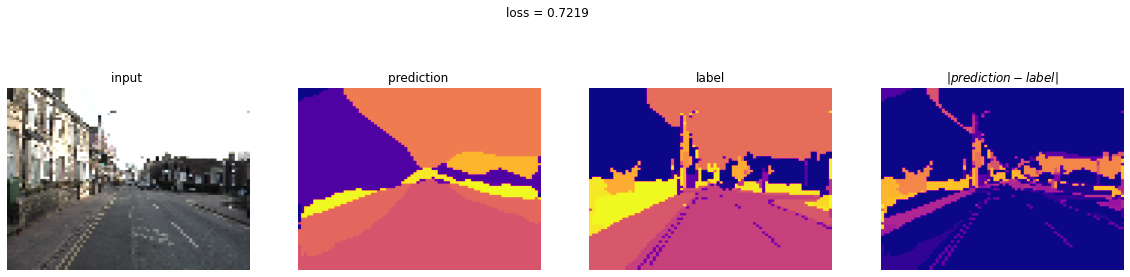

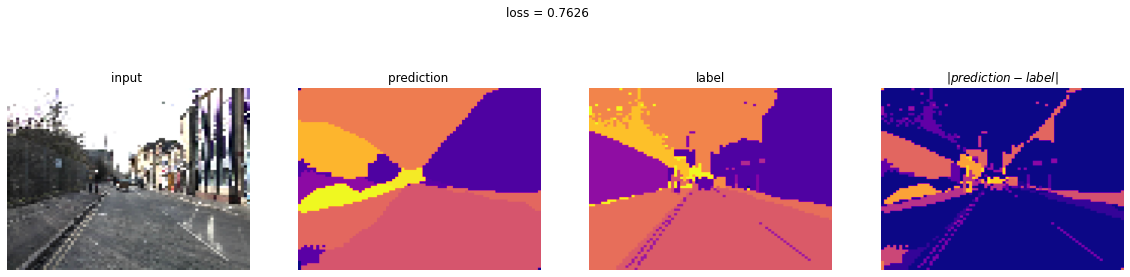

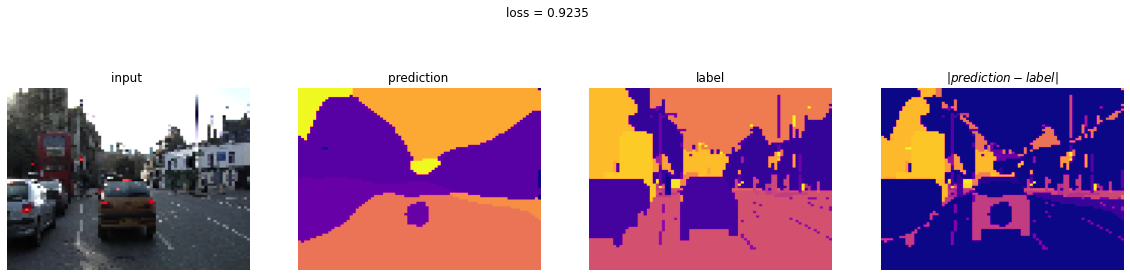

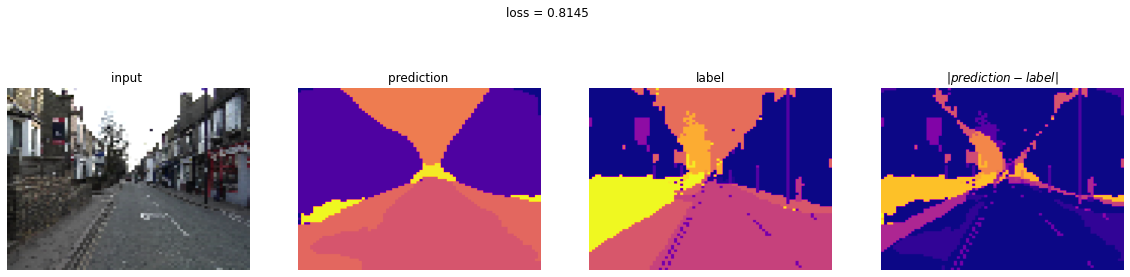

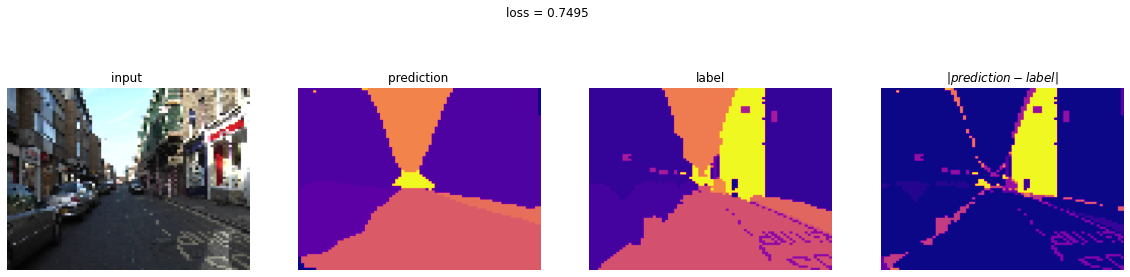

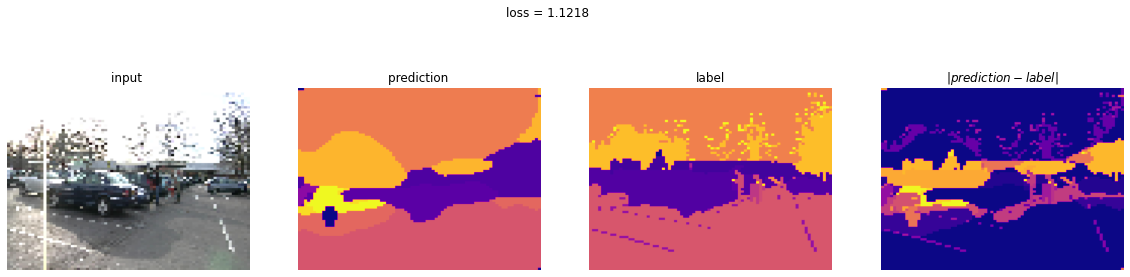

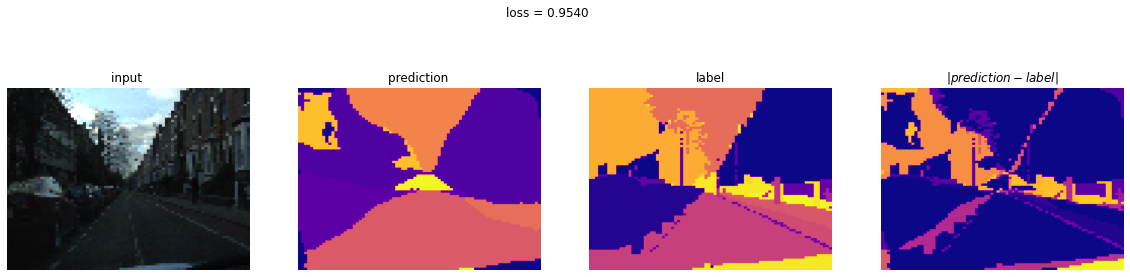

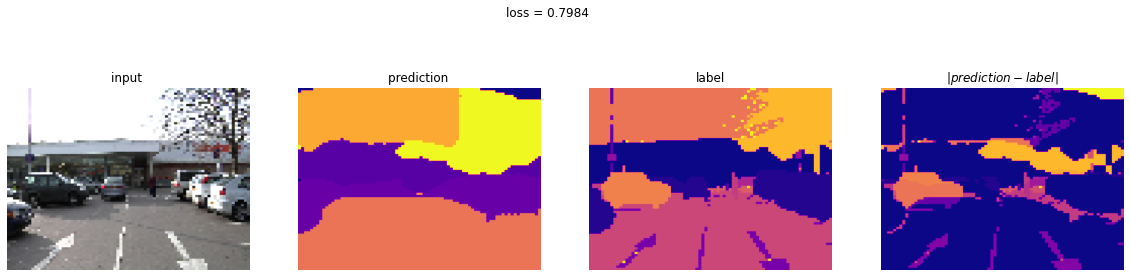

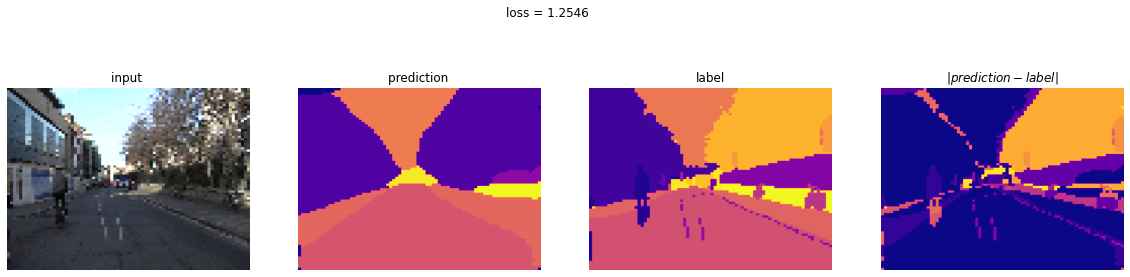

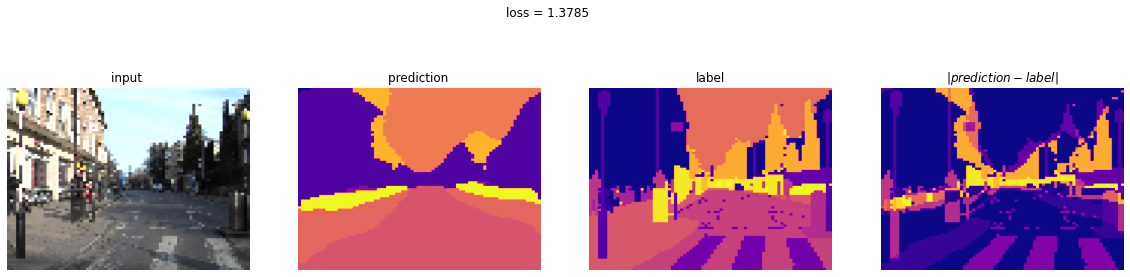

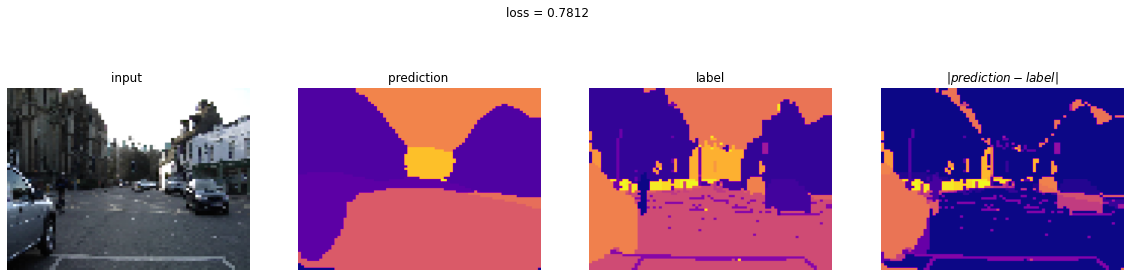

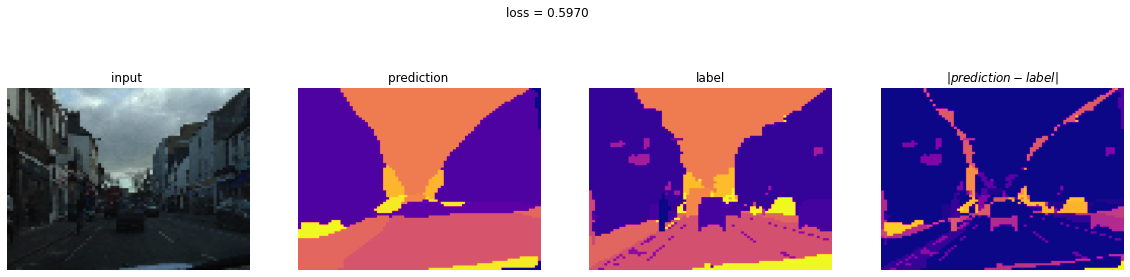

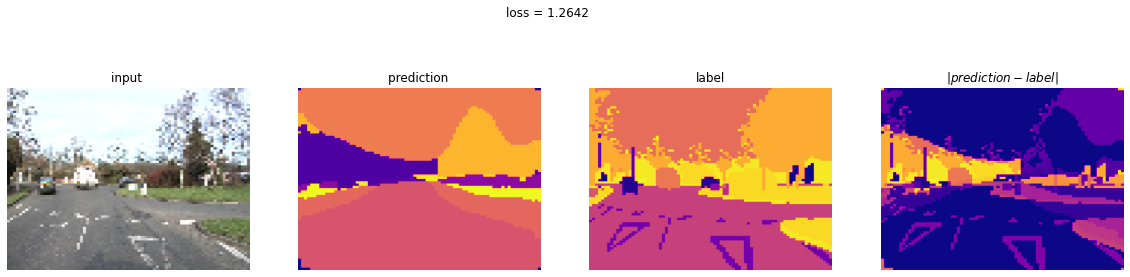

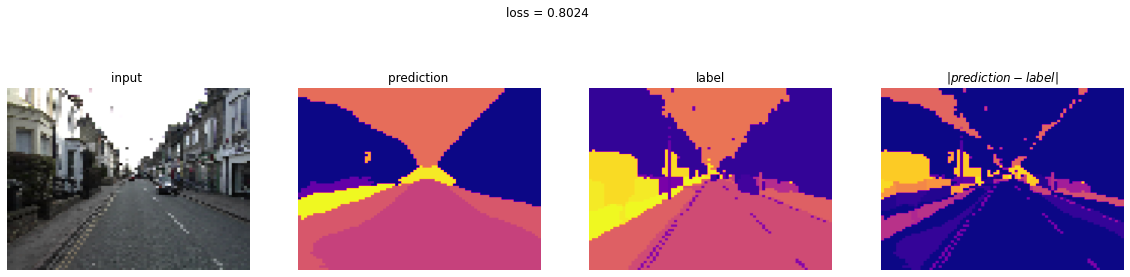

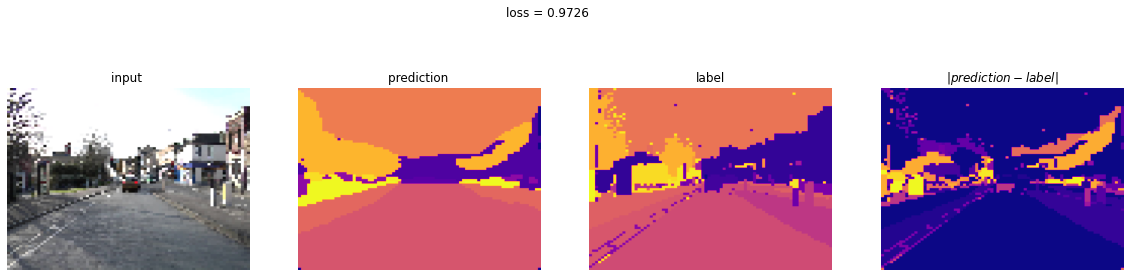

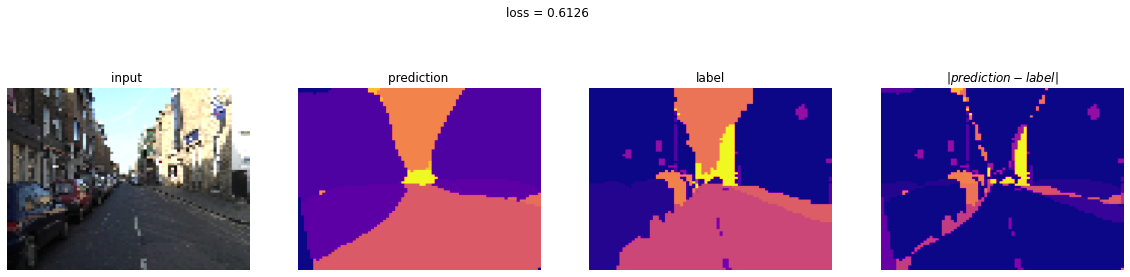

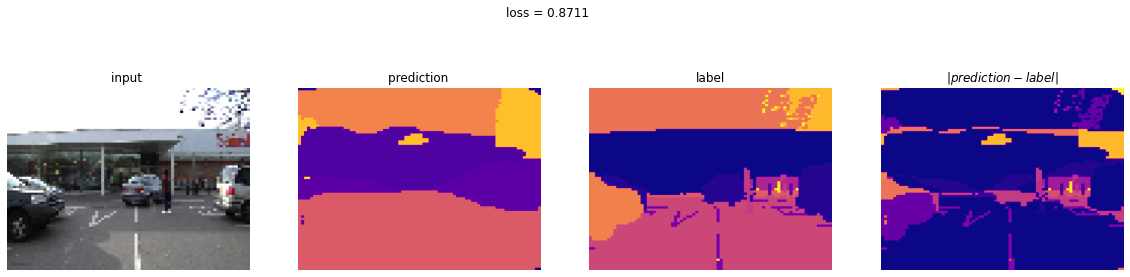

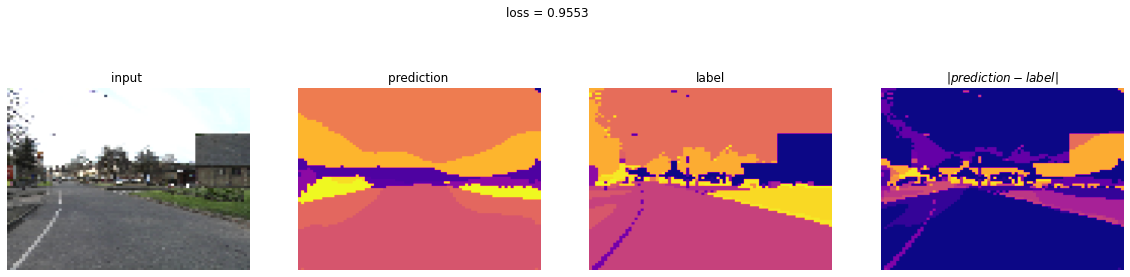

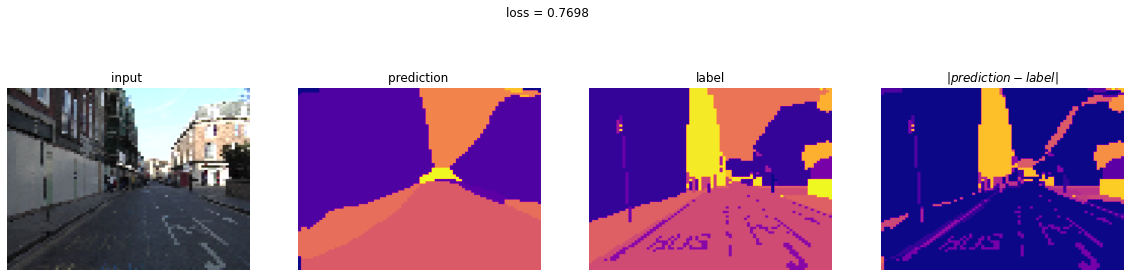

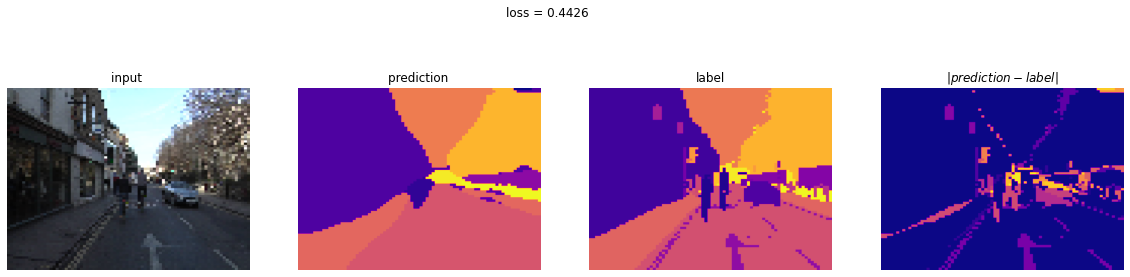

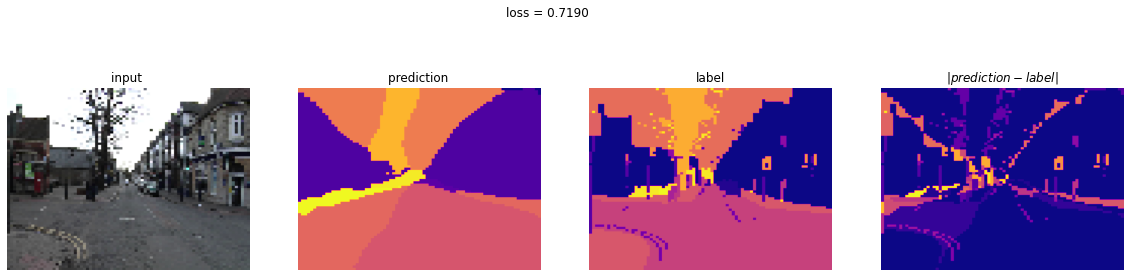

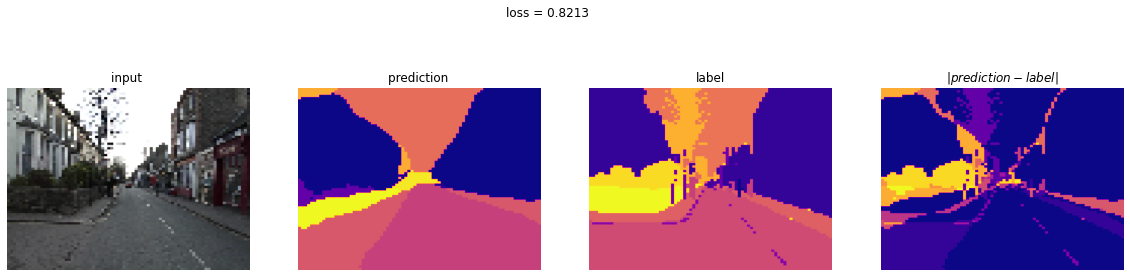

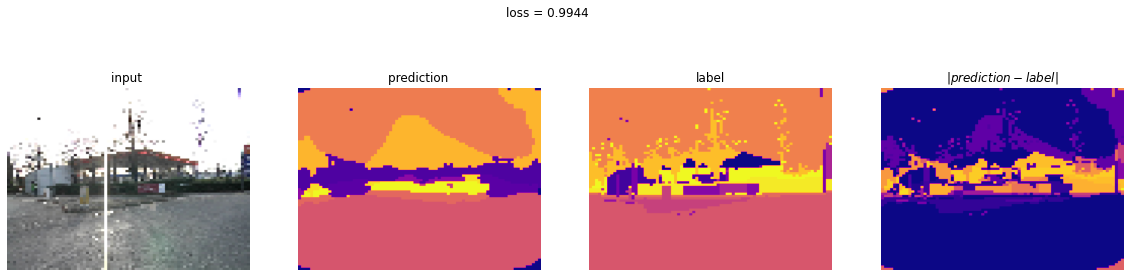

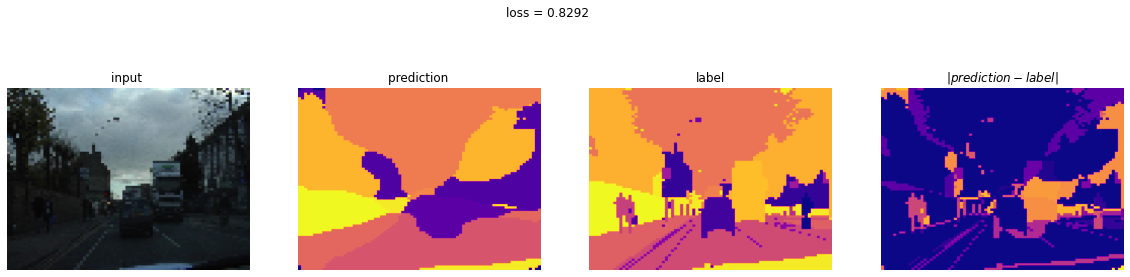

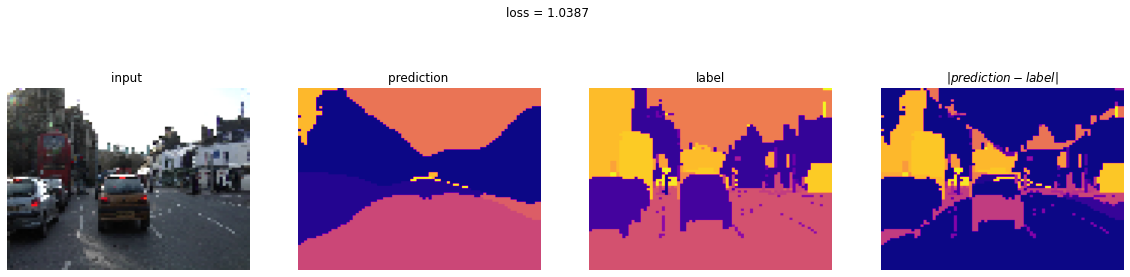

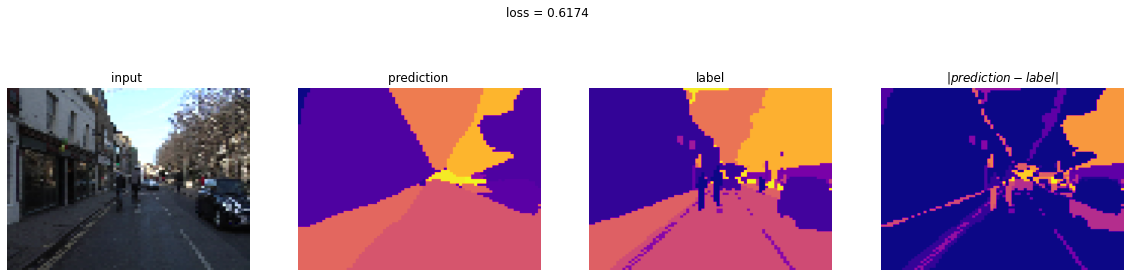

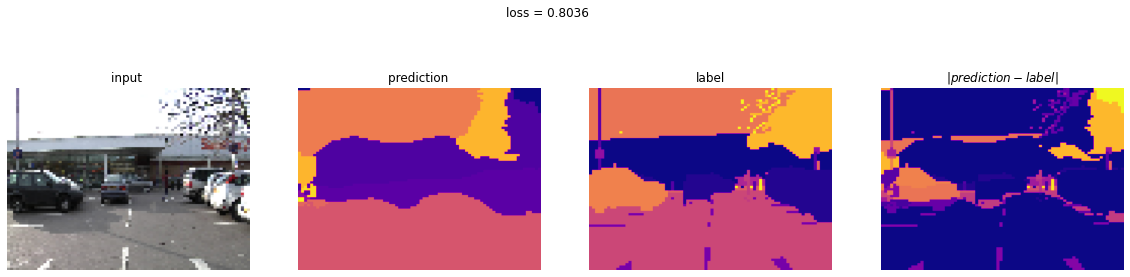

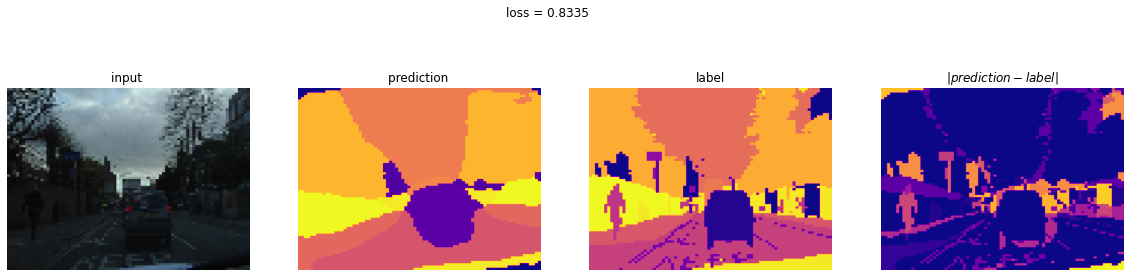

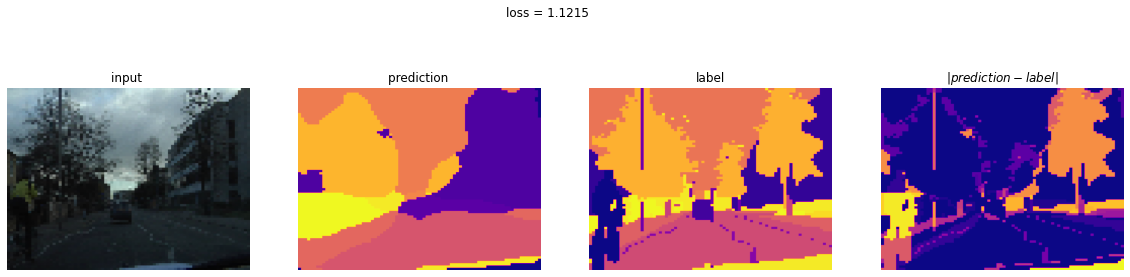

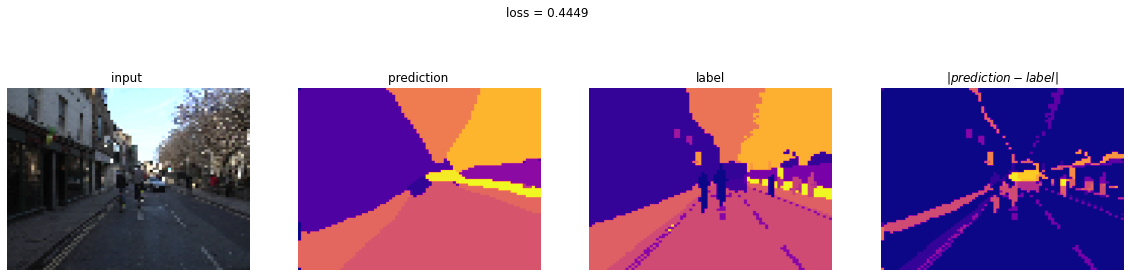

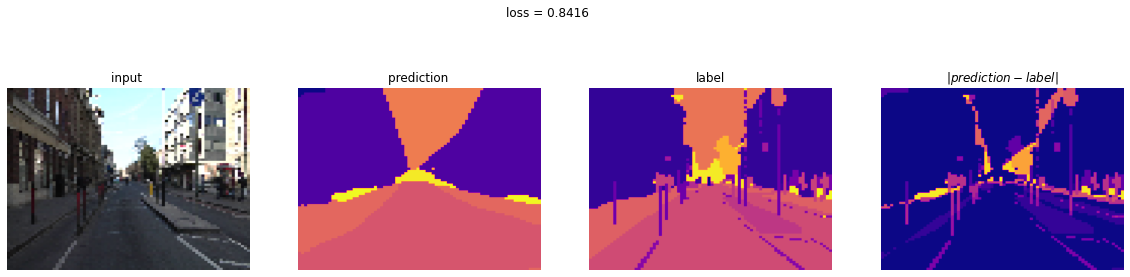

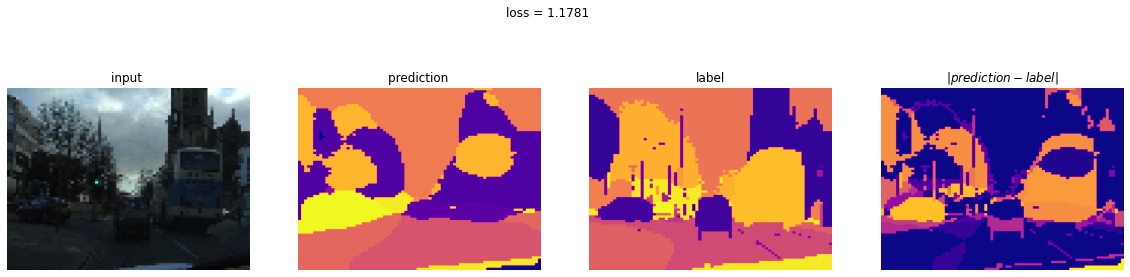

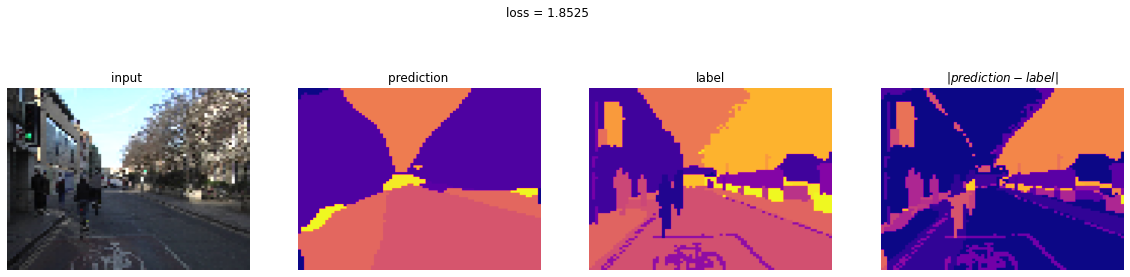

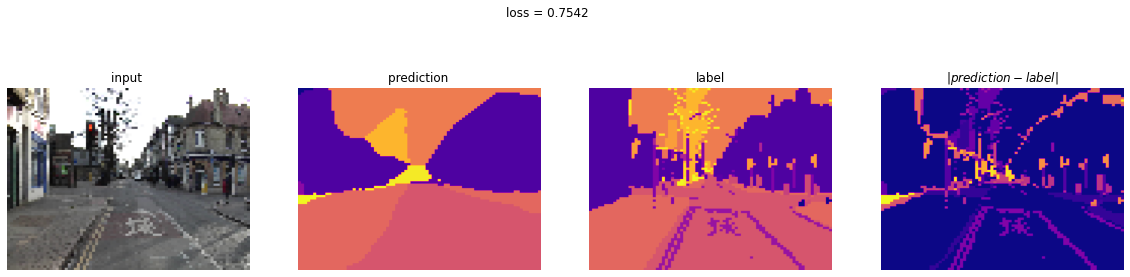

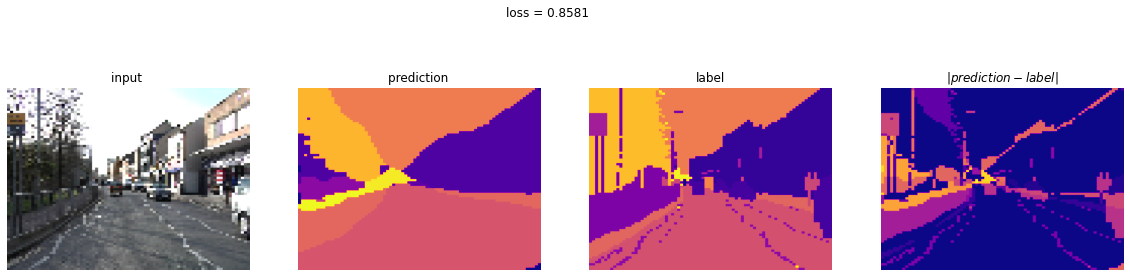

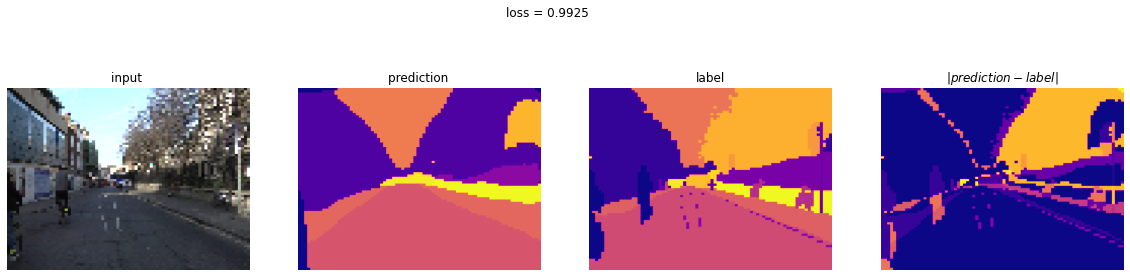

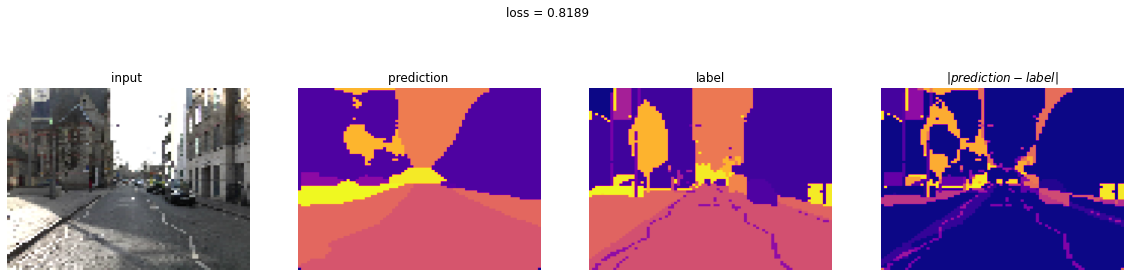

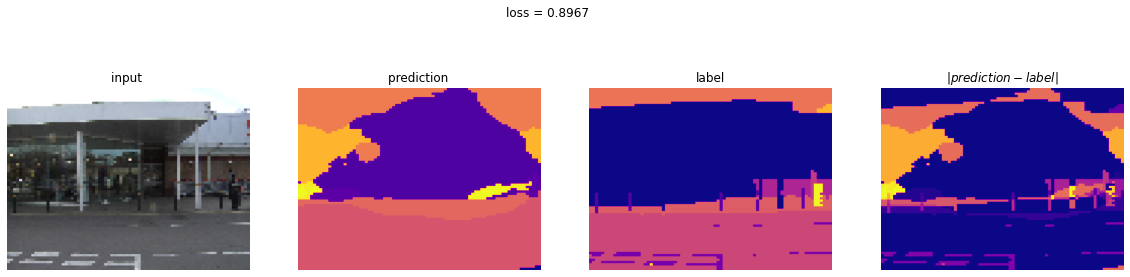

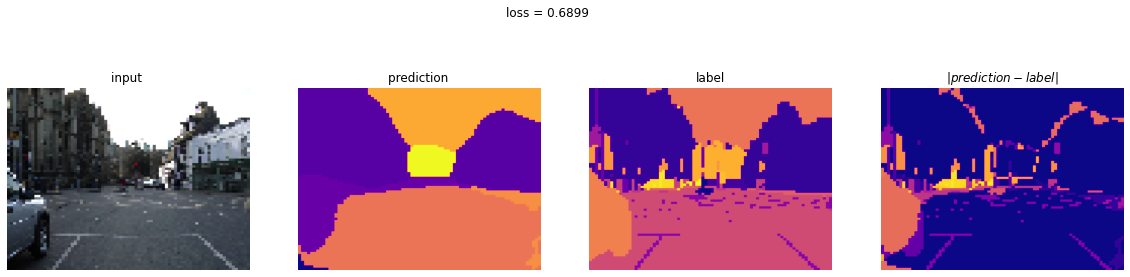

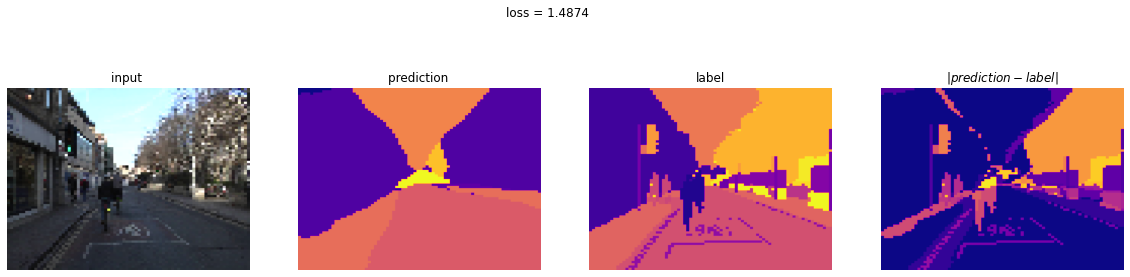

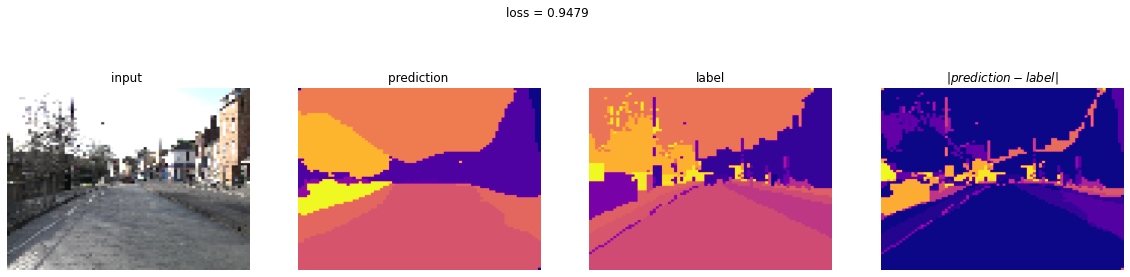

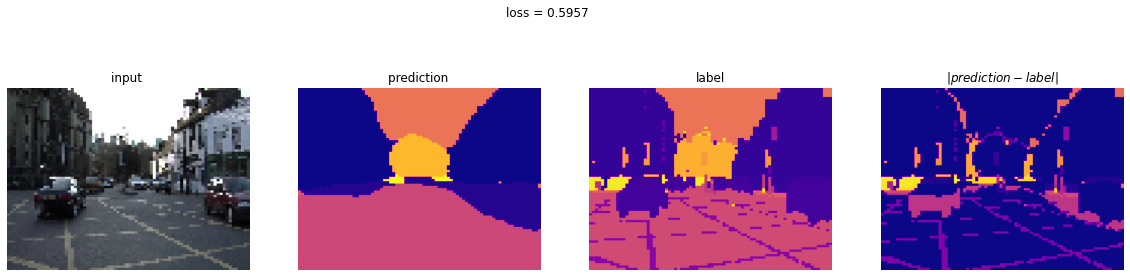

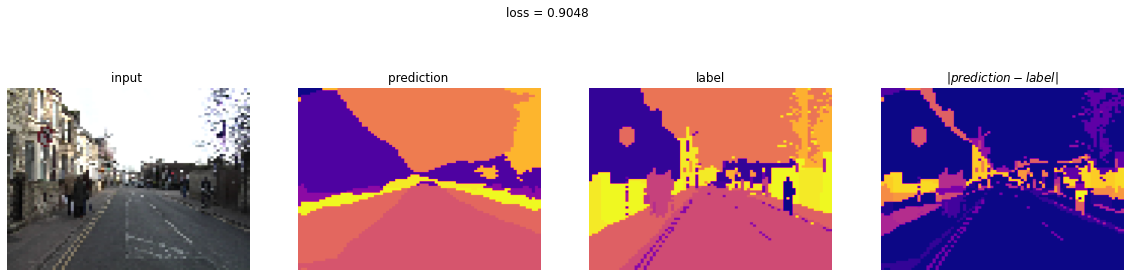

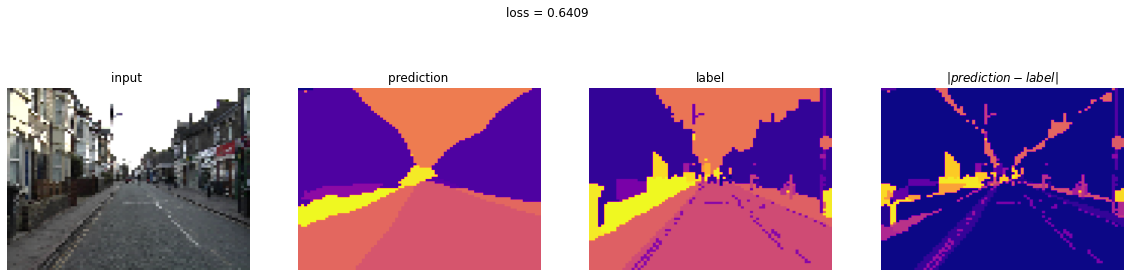

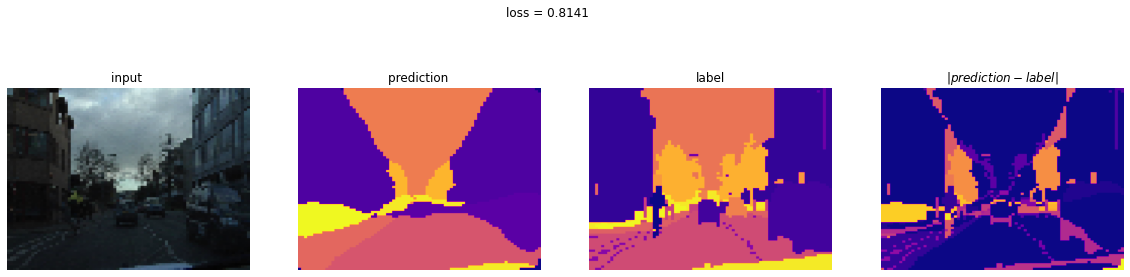

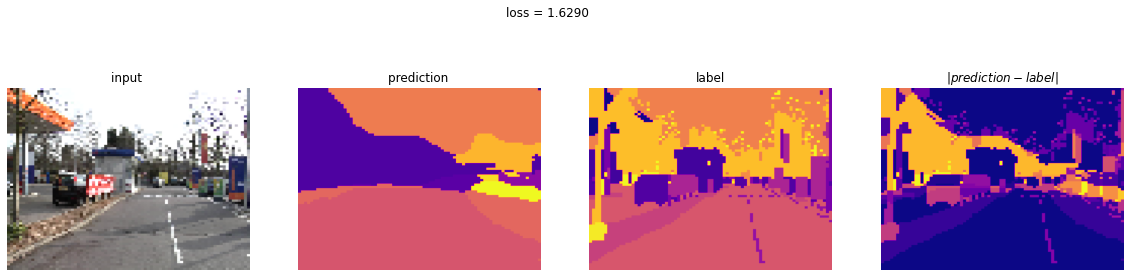

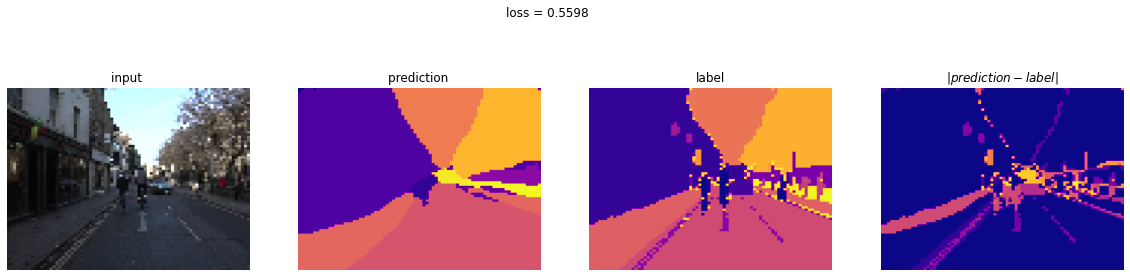

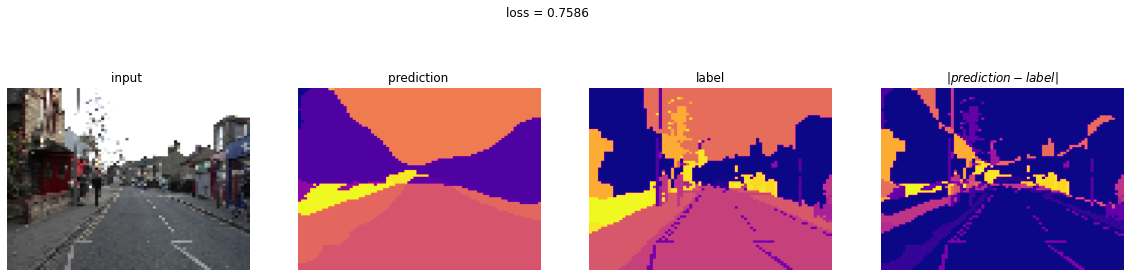

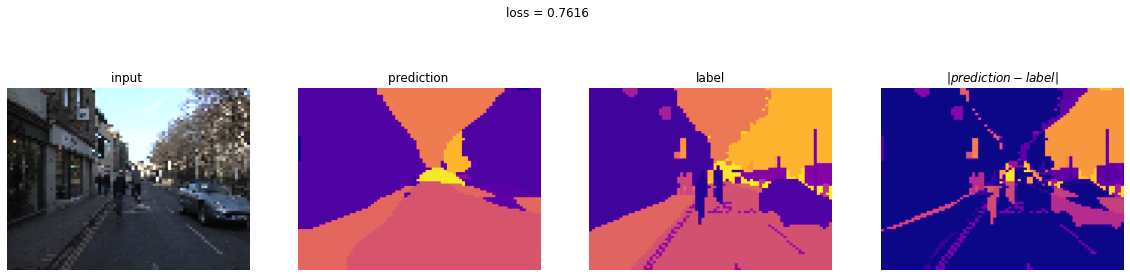

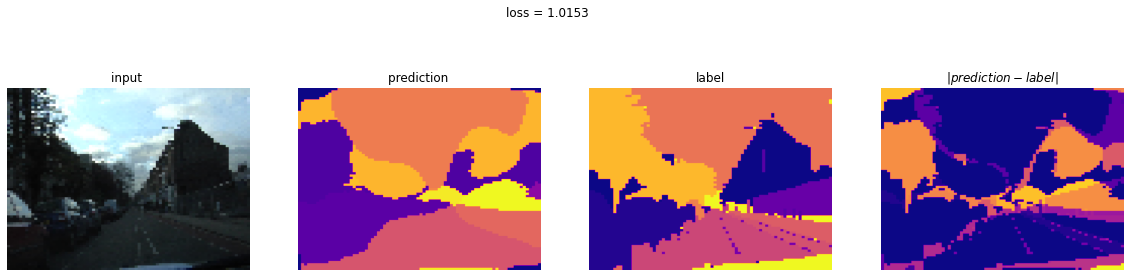

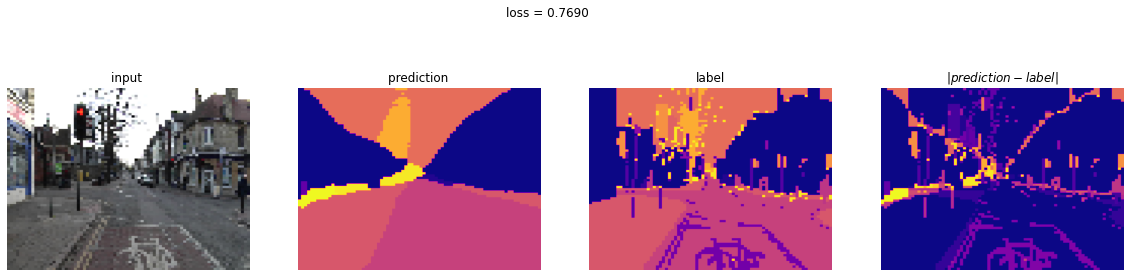

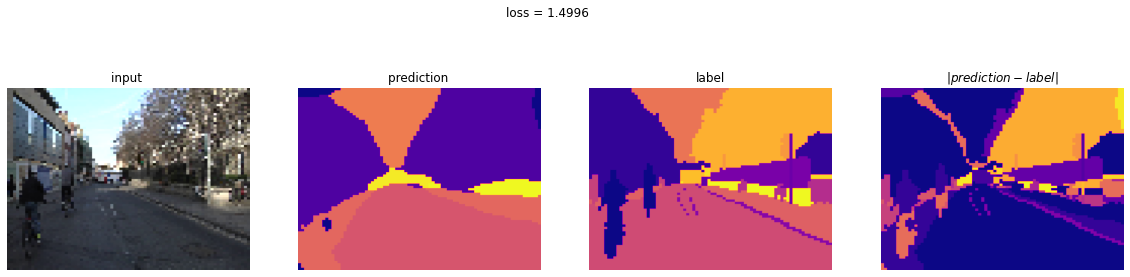

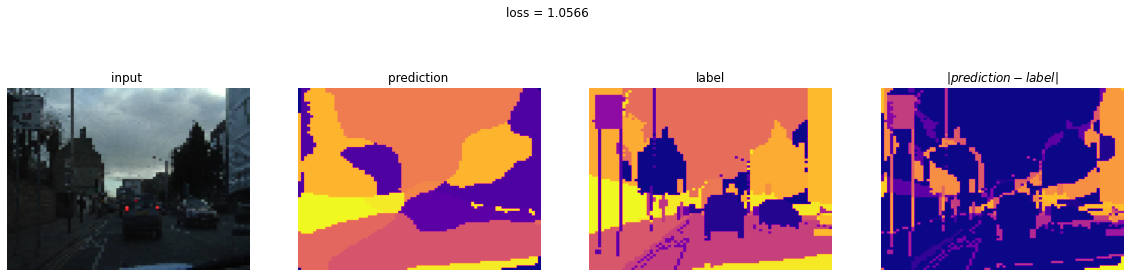

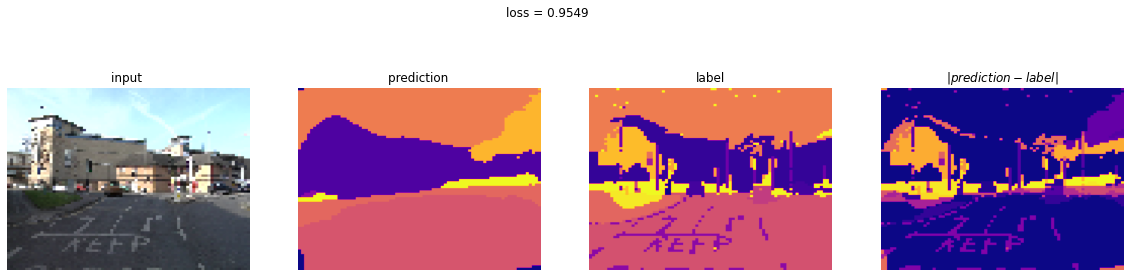

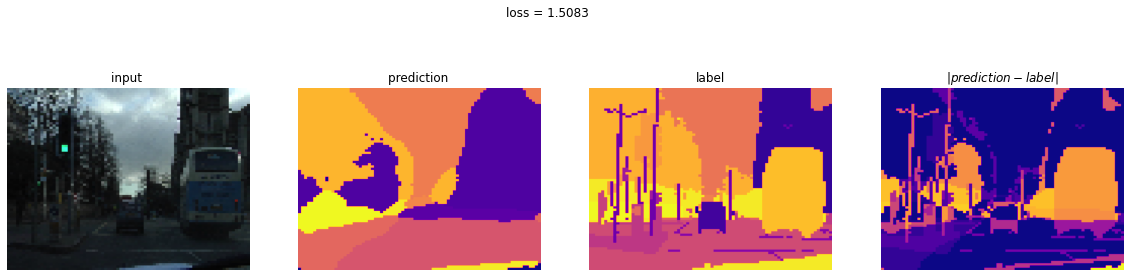

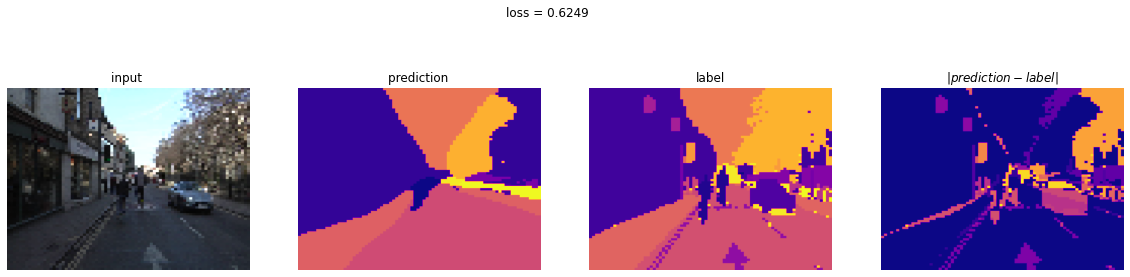

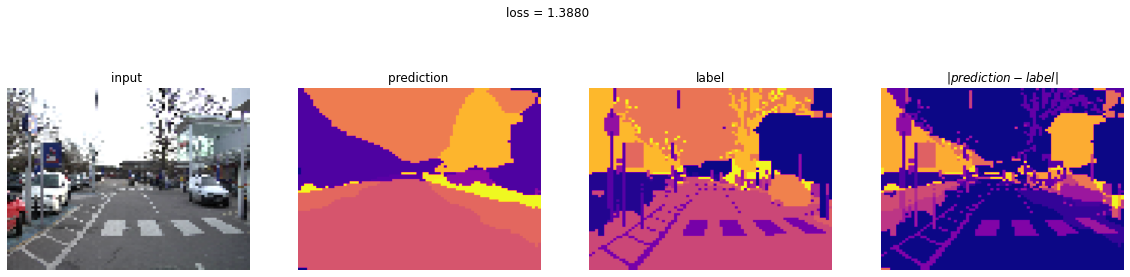

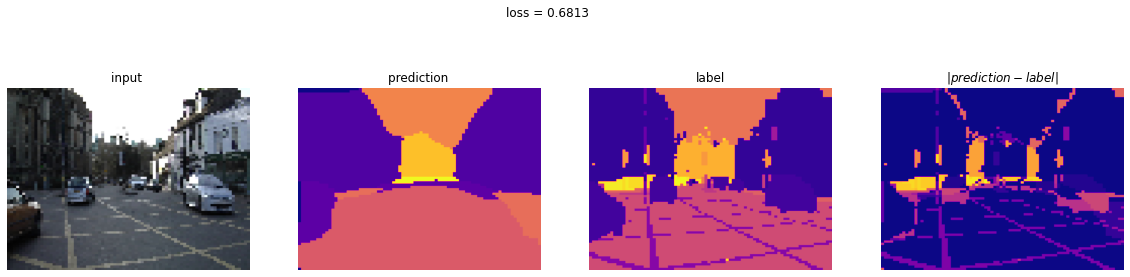

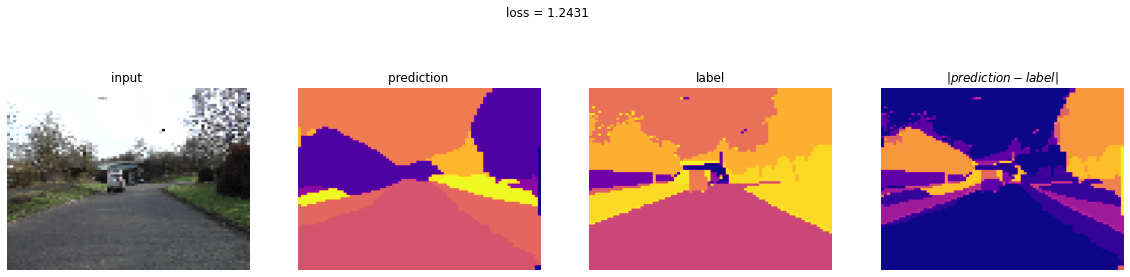

In [ ]:
model=model.to(device)
criterion=nn.CrossEntropyLoss()

for X,y in testloader:
  X=X.to(device)
  
  y=y.to(device)
  out=model(X)
  loss=criterion(out,y)
  loss=loss.item()
  _,pred=torch.max(out,1)
  pred=pred.to('cpu')
  y=y.to('cpu')
  X=X.to('cpu')
  X=X.numpy()
  X=X[0]
  X=X.reshape(80,80,3)
  
  pred=pred.numpy()
  y=y.numpy()
  y=y[0]
  pred=pred[0]
  diff=np.abs(y-pred)
  y=cv2.resize(y,dsize=(960,720),interpolation=cv2.INTER_NEAREST)
  X=cv2.resize(X,dsize=(960,720),interpolation=cv2.INTER_NEAREST)
  diff=cv2.resize(diff,dsize=(960,720),interpolation=cv2.INTER_NEAREST)
  
  pred=cv2.resize(pred,dsize=(960,720),interpolation=cv2.INTER_NEAREST)
  fig=plt.figure(figsize=[20,5])
  fig.suptitle(f'loss = {loss:.4f}')
  plt.subplot(1,4,1)
  plt.imshow(X.astype('int'))
  plt.axis('off')
  plt.title(f'input ')
  plt.subplot(1,4,2)
  plt.imshow(pred*255,cmap='plasma')
  plt.axis('off')
  plt.title(f'prediction ')
  plt.subplot(1,4,3)
  plt.imshow(y,cmap='plasma')
  plt.axis('off')
  plt.title('label')
  plt.subplot(1,4,4)
  plt.imshow(diff,cmap='plasma')
  plt.axis('off')
  plt.title('$|prediction-label|$')